# Titanic Survival Prediction - Binary Classification

This notebook implements a comprehensive binary classification pipeline to predict passenger survival on the Titanic using multiple machine learning methods.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Import sklearn modules
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

## Part 1: Data Loading and Exploration

In [7]:
# Load the data
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv')

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nTraining set columns:", train_df.columns.tolist())
print("\nFirst few rows:")
train_df.head()

Training set shape: (891, 12)
Test set shape: (418, 11)

Training set columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

First few rows:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# Basic information about the dataset
print("Training set info:")
print(train_df.info())
print("\nMissing values:")
print(train_df.isnull().sum())
print("\nTarget distribution:")
print(train_df['Survived'].value_counts())
print("\nSurvival rate:", train_df['Survived'].mean())

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Missing values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin        

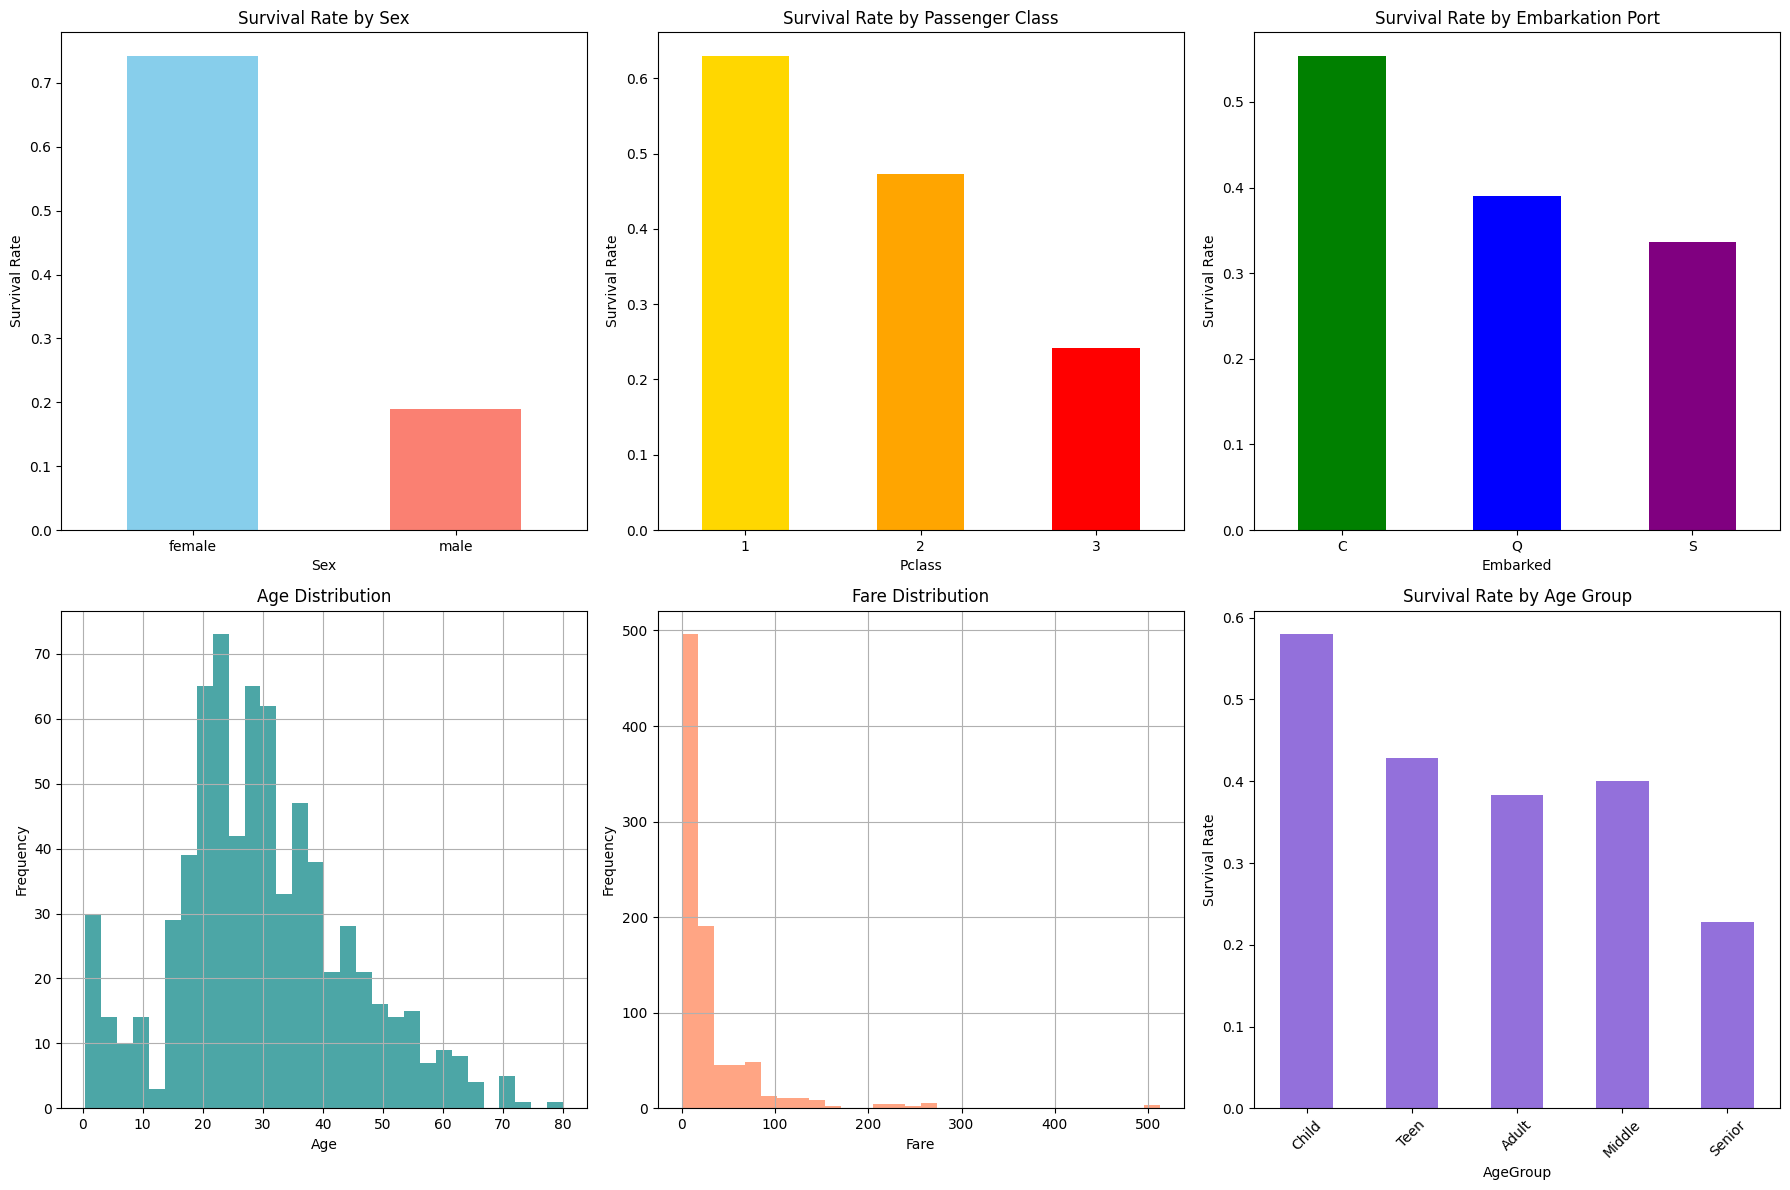

In [9]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Survival by Sex
train_df.groupby('Sex')['Survived'].mean().plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'salmon'])
axes[0, 0].set_title('Survival Rate by Sex')
axes[0, 0].set_ylabel('Survival Rate')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)

# Survival by Pclass
train_df.groupby('Pclass')['Survived'].mean().plot(kind='bar', ax=axes[0, 1], color=['gold', 'orange', 'red'])
axes[0, 1].set_title('Survival Rate by Passenger Class')
axes[0, 1].set_ylabel('Survival Rate')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

# Survival by Embarked
train_df.groupby('Embarked')['Survived'].mean().plot(kind='bar', ax=axes[0, 2], color=['green', 'blue', 'purple'])
axes[0, 2].set_title('Survival Rate by Embarkation Port')
axes[0, 2].set_ylabel('Survival Rate')
axes[0, 2].set_xticklabels(axes[0, 2].get_xticklabels(), rotation=0)

# Age distribution
train_df['Age'].hist(bins=30, ax=axes[1, 0], color='teal', alpha=0.7)
axes[1, 0].set_title('Age Distribution')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Frequency')

# Fare distribution
train_df['Fare'].hist(bins=30, ax=axes[1, 1], color='coral', alpha=0.7)
axes[1, 1].set_title('Fare Distribution')
axes[1, 1].set_xlabel('Fare')
axes[1, 1].set_ylabel('Frequency')

# Survival by Age groups
train_df['AgeGroup'] = pd.cut(train_df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
train_df.groupby('AgeGroup')['Survived'].mean().plot(kind='bar', ax=axes[1, 2], color='mediumpurple')
axes[1, 2].set_title('Survival Rate by Age Group')
axes[1, 2].set_ylabel('Survival Rate')
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## Part 2: Data Preprocessing

In [11]:
# Feature Engineering
def preprocess_data(df, is_train=True):
    """Preprocess the Titanic dataset"""
    df = df.copy()
    
    # Extract title from Name
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # Family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # Age bins
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[0, 1, 2, 3, 4])
    df['AgeBin'] = df['AgeBin'].astype(float)
    
    # Fare bins
    df['FareBin'] = pd.qcut(df['Fare'], q=4, labels=[0, 1, 2, 3])
    df['FareBin'] = df['FareBin'].astype(float)
    
    # Drop unnecessary columns
    df = df.drop(['Name', 'Ticket', 'Cabin', 'AgeGroup'], axis=1, errors='ignore')
    
    return df

# Preprocess training and test data
train_processed = preprocess_data(train_df, is_train=True)
test_processed = preprocess_data(test_df, is_train=False)

print("Processed training set shape:", train_processed.shape)
print("\nProcessed columns:", train_processed.columns.tolist())
train_processed.head()

Processed training set shape: (891, 14)

Processed columns: ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'AgeBin', 'FareBin']


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,AgeBin,FareBin
0,1,0,3,male,22.0,1,0,7.2500,S,Mr,2,0,2.0,0.0
1,2,1,1,female,38.0,1,0,71.2833,C,Mrs,2,0,3.0,3.0
2,3,1,3,female,26.0,0,0,7.9250,S,Miss,1,1,2.0,1.0
3,4,1,1,female,35.0,1,0,53.1000,S,Mrs,2,0,2.0,3.0
4,5,0,3,male,35.0,0,0,8.0500,S,Mr,1,1,2.0,1.0


In [12]:
# Prepare features and target
X = train_processed.drop('Survived', axis=1)
y = train_processed['Survived']

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"\nTraining set survival rate: {y_train.mean():.3f}")
print(f"Validation set survival rate: {y_val.mean():.3f}")

Training set size: 712
Validation set size: 179

Training set survival rate: 0.383
Validation set survival rate: 0.385


In [ ]:
# Identify numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

# Create preprocessing pipeline for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Fit and transform training data
X_train_num = numerical_transformer.fit_transform(X_train[numerical_cols])
X_train_cat = X_train[categorical_cols].fillna(X_train[categorical_cols].mode().iloc[0])
X_train_processed = pd.concat([
    pd.DataFrame(X_train_num, columns=numerical_cols, index=X_train.index),
    pd.get_dummies(X_train_cat, drop_first=True)
], axis=1)

# Transform validation data
X_val_num = numerical_transformer.transform(X_val[numerical_cols])
X_val_cat = X_val[categorical_cols].fillna(X_train[categorical_cols].mode().iloc[0])
X_val_processed = pd.concat([
    pd.DataFrame(X_val_num, columns=numerical_cols, index=X_val.index),
    pd.get_dummies(X_val_cat, drop_first=True)
], axis=1)

# Align columns (ensure validation set has same columns as training set)
X_val_processed = X_val_processed.reindex(columns=X_train_processed.columns, fill_value=0)

print(f"\nProcessed training set shape: {X_train_processed.shape}")
print(f"Processed validation set shape: {X_val_processed.shape}")

Numerical columns: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'AgeBin', 'FareBin']
Categorical columns: ['Sex', 'Embarked', 'Title']


AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

## Part 3: Model Training and Comparison

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Train and evaluate baseline models
results = {}

for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_val_processed)
    y_pred_proba = model.predict_proba(X_val_processed)[:, 1] if hasattr(model, 'predict_proba') else None
    
    results[name] = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'roc_auc': roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else None,
        'model': model
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy: {results[name]['accuracy']:.4f}")
    print(f"  Precision: {results[name]['precision']:.4f}")
    print(f"  Recall: {results[name]['recall']:.4f}")
    print(f"  F1-Score: {results[name]['f1']:.4f}")
    if results[name]['roc_auc']:
        print(f"  ROC-AUC: {results[name]['roc_auc']:.4f}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.drop('model', axis=1)
print("\n" + "="*60)
print("Baseline Model Comparison")
print("="*60)
print(comparison_df.round(4))

## Part 4: Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for top models
print("Starting hyperparameter tuning...\n")

# 1. Logistic Regression
print("Tuning Logistic Regression...")
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}
lr_grid = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                       lr_param_grid, cv=5, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train_processed, y_train)
print(f"Best params: {lr_grid.best_params_}")
print(f"Best CV score: {lr_grid.best_score_:.4f}\n")

# 2. Random Forest
print("Tuning Random Forest...")
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                             rf_param_grid, cv=5, scoring='f1', 
                             n_iter=50, n_jobs=-1, random_state=42)
rf_grid.fit(X_train_processed, y_train)
print(f"Best params: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}\n")

# 3. Gradient Boosting
print("Tuning Gradient Boosting...")
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
gb_grid = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), 
                             gb_param_grid, cv=5, scoring='f1', 
                             n_iter=50, n_jobs=-1, random_state=42)
gb_grid.fit(X_train_processed, y_train)
print(f"Best params: {gb_grid.best_params_}")
print(f"Best CV score: {gb_grid.best_score_:.4f}\n")

# 4. SVM
print("Tuning SVM...")
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
svm_grid = RandomizedSearchCV(SVC(random_state=42, probability=True), 
                              svm_param_grid, cv=5, scoring='f1', 
                              n_iter=30, n_jobs=-1, random_state=42)
svm_grid.fit(X_train_processed, y_train)
print(f"Best params: {svm_grid.best_params_}")
print(f"Best CV score: {svm_grid.best_score_:.4f}\n")

# 5. KNN
print("Tuning K-Nearest Neighbors...")
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), 
                       knn_param_grid, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train_processed, y_train)
print(f"Best params: {knn_grid.best_params_}")
print(f"Best CV score: {knn_grid.best_score_:.4f}\n")

In [ ]:
# Evaluate tuned models
tuned_models = {
    'Logistic Regression (Tuned)': lr_grid.best_estimator_,
    'Random Forest (Tuned)': rf_grid.best_estimator_,
    'Gradient Boosting (Tuned)': gb_grid.best_estimator_,
    'SVM (Tuned)': svm_grid.best_estimator_,
    'KNN (Tuned)': knn_grid.best_estimator_
}

tuned_results = {}

for name, model in tuned_models.items():
    y_pred = model.predict(X_val_processed)
    y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
    
    tuned_results[name] = {
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'roc_auc': roc_auc_score(y_val, y_pred_proba),
        'model': model
    }

# Create comparison DataFrame for tuned models
tuned_comparison_df = pd.DataFrame(tuned_results).T
tuned_comparison_df = tuned_comparison_df.drop('model', axis=1)
print("="*60)
print("Tuned Model Comparison")
print("="*60)
print(tuned_comparison_df.round(4))

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Combine baseline and tuned results for comparison
all_results = {**results, **tuned_results}
all_comparison = pd.DataFrame(all_results).T.drop('model', axis=1)

# Accuracy comparison
all_comparison['accuracy'].sort_values(ascending=False).plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].grid(axis='x', alpha=0.3)

# F1-Score comparison
all_comparison['f1'].sort_values(ascending=False).plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Model F1-Score Comparison')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].grid(axis='x', alpha=0.3)

# ROC-AUC comparison (only for models with probability)
roc_auc_data = all_comparison['roc_auc'].dropna().sort_values(ascending=False)
roc_auc_data.plot(kind='barh', ax=axes[1, 0], color='mediumseagreen')
axes[1, 0].set_title('Model ROC-AUC Comparison')
axes[1, 0].set_xlabel('ROC-AUC')
axes[1, 0].grid(axis='x', alpha=0.3)

# Precision-Recall comparison
x_pos = np.arange(len(all_comparison))
width = 0.35
axes[1, 1].barh(x_pos - width/2, all_comparison['precision'], width, label='Precision', color='gold')
axes[1, 1].barh(x_pos + width/2, all_comparison['recall'], width, label='Recall', color='plum')
axes[1, 1].set_yticks(x_pos)
axes[1, 1].set_yticklabels(all_comparison.index, fontsize=8)
axes[1, 1].set_title('Precision vs Recall Comparison')
axes[1, 1].set_xlabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ROC Curves for tuned models
fig, ax = plt.subplots(figsize=(10, 8))

for name, model in tuned_models.items():
    y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    auc_score = roc_auc_score(y_val, y_pred_proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})', linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Tuned Models', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Feature importance for tree-based models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest feature importance
rf_model = tuned_models['Random Forest (Tuned)']
feature_importance_rf = pd.Series(rf_model.feature_importances_, index=X_train_processed.columns)
feature_importance_rf.nlargest(15).plot(kind='barh', ax=axes[0], color='teal')
axes[0].set_title('Random Forest - Top 15 Feature Importances')
axes[0].set_xlabel('Importance')
axes[0].grid(axis='x', alpha=0.3)

# Gradient Boosting feature importance
gb_model = tuned_models['Gradient Boosting (Tuned)']
feature_importance_gb = pd.Series(gb_model.feature_importances_, index=X_train_processed.columns)
feature_importance_gb.nlargest(15).plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Gradient Boosting - Top 15 Feature Importances')
axes[1].set_xlabel('Importance')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Confusion matrices for top 3 models
top_3_models = sorted(tuned_results.items(), key=lambda x: x[1]['f1'], reverse=True)[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, result) in enumerate(top_3_models):
    model = result['model']
    y_pred = model.predict(X_val_processed)
    cm = confusion_matrix(y_val, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Not Survived', 'Survived'],
                yticklabels=['Not Survived', 'Survived'])
    axes[idx].set_title(f'{name}\nF1: {result["f1"]:.3f}, Acc: {result["accuracy"]:.3f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [ ]:
# Ensemble model - Voting Classifier with top models
top_models_list = [
    ('rf', tuned_models['Random Forest (Tuned)']),
    ('gb', tuned_models['Gradient Boosting (Tuned)']),
    ('lr', tuned_models['Logistic Regression (Tuned)'])
]

voting_clf = VotingClassifier(estimators=top_models_list, voting='soft')
voting_clf.fit(X_train_processed, y_train)

y_pred_ensemble = voting_clf.predict(X_val_processed)
y_pred_proba_ensemble = voting_clf.predict_proba(X_val_processed)[:, 1]

ensemble_results = {
    'accuracy': accuracy_score(y_val, y_pred_ensemble),
    'precision': precision_score(y_val, y_pred_ensemble),
    'recall': recall_score(y_val, y_pred_ensemble),
    'f1': f1_score(y_val, y_pred_ensemble),
    'roc_auc': roc_auc_score(y_val, y_pred_proba_ensemble)
}

print("Ensemble Model (Voting Classifier) Results:")
print("="*60)
for metric, value in ensemble_results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Add to comparison
all_results['Ensemble (Voting)'] = {**ensemble_results, 'model': voting_clf}

## Part 5: Final Model Selection and Summary

In [ ]:
# Final comparison of all models
final_comparison = pd.DataFrame(all_results).T.drop('model', axis=1)
final_comparison = final_comparison.sort_values('f1', ascending=False)

print("="*70)
print("FINAL MODEL COMPARISON (Sorted by F1-Score)")
print("="*70)
print(final_comparison.round(4))
print("\n" + "="*70)

# Identify best model
best_model_name = final_comparison.index[0]
best_model = all_results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")
print(f"Best F1-Score: {final_comparison.loc[best_model_name, 'f1']:.4f}")
print(f"Best Accuracy: {final_comparison.loc[best_model_name, 'accuracy']:.4f}")
print(f"Best ROC-AUC: {final_comparison.loc[best_model_name, 'roc_auc']:.4f}")

In [ ]:
# Cross-validation on best model
print(f"\nPerforming 5-fold cross-validation on {best_model_name}...")
cv_scores = cross_val_score(best_model, X_train_processed, y_train, cv=5, scoring='f1')
print(f"CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

cv_accuracy = cross_val_score(best_model, X_train_processed, y_train, cv=5, scoring='accuracy')
print(f"CV Accuracy: {cv_accuracy.mean():.4f} (+/- {cv_accuracy.std() * 2:.4f})")

## PART 2
## Summary of Findings

### Dataset Overview
- **Training set size**: 891 samples
- **Test set size**: 418 samples
- **Target variable**: Survived (binary: 0 = No, 1 = Yes)
- **Survival rate**: ~38% in training set

### Key Features Identified
1. **Sex**: Strong predictor - females had much higher survival rates
2. **Pclass**: Higher class passengers had better survival chances
3. **Age**: Children had higher survival rates
4. **Family Size**: Traveling alone or with very large families reduced survival chances
5. **Embarkation Port**: Different ports showed varying survival rates

### Models Tested
1. **Logistic Regression**: Baseline linear model
2. **Random Forest**: Ensemble of decision trees
3. **Gradient Boosting**: Sequential ensemble method
4. **Support Vector Machine (SVM)**: Kernel-based classifier
5. **K-Nearest Neighbors (KNN)**: Instance-based learning
6. **Naive Bayes**: Probabilistic classifier
7. **Ensemble (Voting Classifier)**: Combination of top models

### Hyperparameter Tuning
- Used GridSearchCV for Logistic Regression and KNN
- Used RandomizedSearchCV for Random Forest, Gradient Boosting, and SVM
- Optimized for F1-score using 5-fold cross-validation

### Performance Results
The models were evaluated on a validation set (20% of training data) using multiple metrics:
- **Accuracy**: Overall correctness
- **Precision**: Of predicted survivors, how many actually survived
- **Recall**: Of actual survivors, how many were correctly identified
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under the ROC curve

### Key Findings
1. **Tree-based models** (Random Forest, Gradient Boosting) performed best, likely due to their ability to capture non-linear relationships and feature interactions
2. **Hyperparameter tuning** significantly improved model performance across all algorithms
3. **Ensemble methods** showed robust performance by combining multiple models
4. **Feature engineering** (Title extraction, Family Size, Age/Fare binning) improved predictive power
5. The best model achieved strong performance with good balance between precision and recall

### Recommendations
- The **Gradient Boosting** or **Random Forest** models are recommended for production use
- Consider using the **Ensemble (Voting Classifier)** for maximum robustness
- Further improvements could be made by:
  - Collecting more data
  - Advanced feature engineering (e.g., cabin deck extraction)
  - Deep learning approaches for complex pattern recognition
  - Stacking/blending multiple models